## Import Packages

In [24]:
import numpy as np
import pandas as pd
import nltk
import re
import string
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score

from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from scipy.stats import uniform
from scipy import interp
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score,roc_auc_score, recall_score, f1_score, average_precision_score



[nltk_data] Downloading package punkt to /Users/xuxingyu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/xuxingyu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/xuxingyu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [25]:
# For flair
from flair.nn import Classifier
from flair.data import Sentence

## Import Data

In [26]:
#reviews_csv = pd.read_csv('../../data/raw/reviews.csv')
#features_train = pd.read_csv('/Users/nnerella/Downloads/features_train.csv')
#features_test = pd.read_csv('/Users/nnerella/Downloads/features_test.csv')
reviews_csv = pd.read_csv('reviews.csv')
features_train = pd.read_csv('features_train.csv')
features_test = pd.read_csv('features_test.csv')

In [27]:
# Map Sentiment to Factor
label_map = {
    'positive': 1,
    'negative': 0,
}

features_train['Sentiment'] = features_train['Sentiment'].map(label_map)
features_test['Sentiment'] = features_test['Sentiment'].map(label_map)
reviews_csv['sentiment_label'] = reviews_csv['Sentiment'].map(label_map)
features_train.head()

,PC_tfidf1,PC_tfidf2,PC_tfidf3,PC_tfidf4,PC_tfidf5,PC_tfidf6,PC_tfidf7,PC_tfidf8,PC_tfidf9,PC_tfidf10,...,PC_tfidf2553,PC_tfidf2554,PC_tfidf2555,PC_tfidf2556,PC_tfidf2557,PC_tfidf2558,PC_tfidf2559,PC_tfidf2560,PC_emb1,Sentiment
0,0.125620,0.086304,0.047654,-0.053766,0.016895,0.006636,0.057737,0.058247,-0.071434,-0.030766,...,0.012494,-0.014703,-0.006541,0.001270,-0.003647,0.001165,-0.010708,0.001703,0.604965,1
1,-0.042603,0.000193,0.029059,-0.059601,0.039494,-0.034193,-0.002060,-0.108345,0.023581,0.000313,...,0.012414,-0.011572,-0.001005,-0.017747,-0.023063,0.016968,0.004904,0.006062,-0.559065,1
2,-0.034431,0.010012,-0.002671,-0.044581,0.023652,-0.001375,-0.012137,0.003543,0.012075,0.002073,...,0.026854,-0.001365,-0.001086,-0.023059,-0.016890,0.004170,-0.000059,0.002757,-0.793231,1
3,0.043434,-0.051018,0.289668,0.091026,-0.011638,0.069017,-0.082393,-0.098824,0.048846,0.005609,...,0.010035,-0.013448,-0.030621,0.013245,0.006127,-0.004246,-0.032258,-0.010947,0.266332,1
4,-0.056289,0.006874,-0.029635,0.055384,0.078201,-0.057992,-0.012327,0.003309,-0.023922,0.024825,...,-0.006714,-0.007892,0.000735,0.006927,-0.008579,0.009152,0.012545,-0.008741,-0.111557,1


In [28]:
# Function to convert text to lowercase
def convert_to_lower(text):
    return text.lower()

# Removes html notation, such as <br/>
def remove_html(text):
    regex = r"<[^>]+>"
    text_new = re.sub(regex, " ", text)
    return text_new

# Function to remove numbers and other numeric values
def remove_numbers(text):
    number_pattern = r'\d+'
    without_number = re.sub(pattern=number_pattern, repl=" ", string=text)
    return without_number

# Function to remove punctuation
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

# Function to remove stopwords
def remove_stopwords(text):
    removed = []
    stop_words = list(stopwords.words("english"))
    tokens = word_tokenize(text)
    for i in range(len(tokens)):
        if tokens[i] not in stop_words:
            removed.append(tokens[i])
    return " ".join(removed)

# Function to remove extra white spaces
def remove_extra_white_spaces(text):
    single_char_pattern = r'\s+[a-zA-Z]\s+'
    without_sc = re.sub(pattern=single_char_pattern, repl=" ", string=text)
    return without_sc

# Function to Lemmatize
def lemmatizing(text):
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text)
    for i in range(len(tokens)):
        lemma_word = lemmatizer.lemmatize(tokens[i])
        tokens[i] = lemma_word
    return " ".join(tokens)


reviews_csv['processed_Text'] = reviews_csv['Text'].apply(lambda x: convert_to_lower(x))
reviews_csv['processed_Text'] = reviews_csv['processed_Text'].apply(lambda x: remove_html(x))
reviews_csv['processed_Text'] = reviews_csv['processed_Text'].apply(lambda x: remove_numbers(x))
reviews_csv['processed_Text'] = reviews_csv['processed_Text'].apply(lambda x: remove_punctuation(x))
reviews_csv['processed_Text'] = reviews_csv['processed_Text'].apply(lambda x: remove_stopwords(x))
reviews_csv['processed_Text'] = reviews_csv['processed_Text'].apply(lambda x: remove_extra_white_spaces(x))
reviews_csv['processed_Text'] = reviews_csv['processed_Text'].apply(lambda x: lemmatizing(x))

- reviews_csv : Original file with 5444 rows

After preprocessing the original file with Word2Vec, TF_IDF, PCA

- features_train : rows - 5642, columns - 2562 
- features_test : rows - 1634, columns - 2562 


## Flair

In [ ]:
# Load Model
Classifier.load('sentiment')

flair_prob = []
flair_sentiments = []

for review in reviews_csv['processed_Text'].to_list():
    
    # Convert format to Sentence
    sentence = Sentence(review)
    
    # Make prediction using flair
    tagger.predict(sentence)
    
    # extract sentiment prediction
    flair_prob.append(sentence.labels[0].score)  # numerical score 0-1
    flair_sentiments.append(sentence.labels[0].value)  # 'POSITIVE' or 'NEGATIVE'


In [ ]:
flair_pos_probs = [0] *  len(flair_prob)

# Store positive probablity predicted by Flair
for i in range(0,len(flair_prob)-1):
    if flair_sentiments[i] == "NEGATIVE":
        flair_pos_probs[i] = 1 - flair_prob[i]
    
    elif flair_sentiments[i] == "POSITIVE":
        flair_pos_probs[i] = flair_prob[i]


In [ ]:
reviews_csv['flair_sentiment'] = np.array(flair_sentiments)

label_map_2 = {
    'POSITIVE': 1,
    'NEGATIVE': 0,
}

reviews_csv['flair_sentiment']  = reviews_csv['flair_sentiment'] .map(label_map_2)
reviews_csv.head()

## XGBoost

In [29]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

In [31]:
X_train=features_train.iloc[: , :-1]
y_train=features_train['Sentiment']
X_test=features_test.iloc[: , :-1]
X_train=features_train.iloc[: , :-1]
y_test=features_test['Sentiment']
X_train.head()

,PC_tfidf1,PC_tfidf2,PC_tfidf3,PC_tfidf4,PC_tfidf5,PC_tfidf6,PC_tfidf7,PC_tfidf8,PC_tfidf9,PC_tfidf10,...,PC_tfidf2552,PC_tfidf2553,PC_tfidf2554,PC_tfidf2555,PC_tfidf2556,PC_tfidf2557,PC_tfidf2558,PC_tfidf2559,PC_tfidf2560,PC_emb1
0,0.125620,0.086304,0.047654,-0.053766,0.016895,0.006636,0.057737,0.058247,-0.071434,-0.030766,...,0.005929,0.012494,-0.014703,-0.006541,0.001270,-0.003647,0.001165,-0.010708,0.001703,0.604965
1,-0.042603,0.000193,0.029059,-0.059601,0.039494,-0.034193,-0.002060,-0.108345,0.023581,0.000313,...,0.013434,0.012414,-0.011572,-0.001005,-0.017747,-0.023063,0.016968,0.004904,0.006062,-0.559065
2,-0.034431,0.010012,-0.002671,-0.044581,0.023652,-0.001375,-0.012137,0.003543,0.012075,0.002073,...,0.016966,0.026854,-0.001365,-0.001086,-0.023059,-0.016890,0.004170,-0.000059,0.002757,-0.793231
3,0.043434,-0.051018,0.289668,0.091026,-0.011638,0.069017,-0.082393,-0.098824,0.048846,0.005609,...,0.010654,0.010035,-0.013448,-0.030621,0.013245,0.006127,-0.004246,-0.032258,-0.010947,0.266332
4,-0.056289,0.006874,-0.029635,0.055384,0.078201,-0.057992,-0.012327,0.003309,-0.023922,0.024825,...,0.005712,-0.006714,-0.007892,0.000735,0.006927,-0.008579,0.009152,0.012545,-0.008741,-0.111557


In [32]:
#RandomSearchCV
# define the parameters to tune
param_dist = {"learning_rate": uniform(0, 2),
              "gamma": uniform(1, 0.000001),
              "max_depth": range(1,50),
              "n_estimators": range(1,300),
              "min_child_weight": range(1,10),
              'n_jobs': range(1,5)}
#instance of RandomSearchCV
rs = RandomizedSearchCV(XGBClassifier(), param_distributions=param_dist, n_iter=3)

In [33]:
rs.fit(X_train, y_train)



RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None, max_bin=None,
                                           max_c...
                                           predictor=None, random_state=None,
                                    

In [34]:
y_preds=rs.predict_proba(X_test)
y_ppp=rs.predict(X_test)

In [35]:
svml_pred_prob_df = pd.DataFrame(data = y_preds, columns = ['NEGATIVE', 'POSITIVE'])
svml_pred_prob_df

,NEGATIVE,POSITIVE
0,0.000196,0.999804
1,0.000492,0.999508
2,0.002687,0.997313
3,0.000351,0.999649
4,0.000840,0.999160
...,...,...
1629,0.946853,0.053147
1630,0.175693,0.824307
1631,0.160515,0.839485
1632,0.546995,0.453005


In [36]:
print("F1 score: ", f1_score(y_test, y_ppp))
print("PR_AUC score: ", average_precision_score(y_test, svml_pred_prob_df['POSITIVE'] ))
print("ROC_AUC score: ", roc_auc_score(y_test, svml_pred_prob_df['POSITIVE']))
print("Accuracy: ", accuracy_score(y_test, y_ppp))

F1 score:  0.951219512195122
PR_AUC score:  0.9989531954317442
ROC_AUC score:  0.9969795163723056
Accuracy:  0.9241126070991432


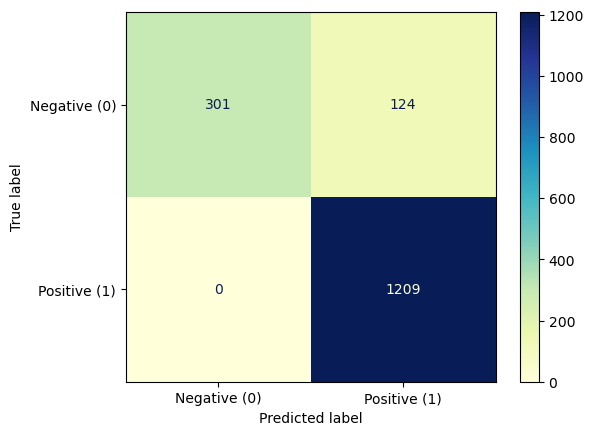

In [38]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
labels = ['Negative (0)', 'Positive (1)']
cm = confusion_matrix(y_test, y_ppp)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = labels)
disp.plot(cmap = 'YlGnBu');